In [47]:
import LanusStats as ls
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import unicodedata
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

In [ ]:
#Importamos los datos
df_RTJ2024 = pd.read_csv('RTJ2024_y_Rendimiento3_torneos_anteriores.csv', index_col=0) #Rendimiento jugadores 2024 y rendimiento de los equipos en los 3 años anteriores
df_Historial_Partidos = pd.read_csv('Historial_partidos_porcentajes.csv', index_col=0) #Historial de partidos entre los equipos en forma porcdentual
df_Fixture = pd.read_csv('Fixture2025.csv', index_col=0) #Fixture 2025
df_estadisticas = pd.read_csv('Estadisticas_actuales', index_col=0)

df_Fixture = df_Fixture.merge(df_Historial_Partidos, how="left", left_on=["Local", "Visitante"], right_on=["Equipo1", "Equipo2"])
df_Fixture.drop(columns=["Equipo1", "Equipo2"], inplace=True)

df_merged = df_Fixture.merge(df_RTJ2024, left_on="Local", right_on="Equipo", how="left", suffixes=("_local", ""))
df_merged = df_merged.merge(df_estadisticas, left_on="Local", right_on="Equipo", how="left", suffixes=("_local", ""))
df_merged = df_merged.merge(df_RTJ2024, left_on="Visitante", right_on="Equipo", how="left", suffixes=("", "_visitante"))
df_mer = df_merged.merge(df_estadisticas, left_on="Visitante", right_on="Equipo", how="left", suffixes=("", "_visitante"))

#pd.set_option('display.max_columns', None)
df_merged = df_mer[["Fecha", "Local" , "Visitante" , "PJ" , "PV" , "PE", "PD", "PGF", "PGC","RTJ2024", "Puntaje_TACT" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L" , "xg" ,"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]

def asignar_resultado(row):
    if row["PGF"] > row["PGC"]:
        return 1  # Gana local
    elif row["PGF"] < row["PGC"]:
        return 2  # Gana visitante
    else:
        return 0  # Empate
df_merged.replace(np.nan, 0, inplace=True)
df_merged["Resultado"] = df_merged.apply(asignar_resultado, axis=1)

import numpy as np

def ajustar_goles_esperados(row):
    diferencia = abs(row["Puntaje_TACT"] - row["Puntaje_TACT_visitante"])
    
    # Si la diferencia es pequeña, acercamos los valores para incentivar el empate
    if diferencia < 0.3:
        ajuste = np.random.uniform(-0.2, 0.2)  # Pequeño ruido aleatorio
        row["Puntaje_TACT"] += ajuste
        row["Puntaje_TACT_visitante"] -= ajuste
    
    # Pequeño sesgo a favor del local
    row["Puntaje_TACT"] += 0.1  

    return row

df_merged = df_merged.apply(ajustar_goles_esperados, axis=1)

In [ ]:
campeones = []
for i in range(1000):

    # Poisson con los valores ajustados
    df_merged["PGF_ajustado"] = np.random.poisson(df_merged["Puntaje_TACT"] * 1.1)  # Más goles para locales
    df_merged["PGC_ajustado"] = np.random.poisson(df_merged["Puntaje_TACT_visitante"] * 0.9)

    # Variables predictoras
    X = df_merged[["PV", "PE", "PD", "Puntaje_TACT" , "RTJ2024" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L"  , "xg" ,	"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]

    
    y_local = df_merged["PGF_ajustado"]
    y_visitante = df_merged["PGC_ajustado"]

    # Dividir en train-test
    X_train, X_test, y_train_local, y_test_local = train_test_split(X, y_local, test_size=0.2, random_state=42)
    X_train, X_test, y_train_visitante, y_test_visitante = train_test_split(X, y_visitante, test_size=0.2, random_state=42)

    # Entrenar modelos
    modelo_local = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo_local.fit(X_train, y_train_local)

    modelo_visitante = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo_visitante.fit(X_train, y_train_visitante)

    # Predicciones
    df_merged["Pred_Goles_Local"] = modelo_local.predict(X)
    df_merged["Pred_Goles_Visitante"] = modelo_visitante.predict(X)

    umbral_empate = 0.4  # Se puede ajustar

    def ajustar_resultado(row, umbral=umbral_empate):
        diferencia = abs(row["PGF_ajustado"] - row["PGC_ajustado"])
        
        if diferencia < umbral:
            return 0  # Empate
        elif row["PGF_ajustado"] > row["PGC_ajustado"]:
            return 1  # Victoria local
        else:
            return 2  # Victoria visitante

    df_merged["Resultado_Ajustado"] = df_merged.apply(lambda row: ajustar_resultado(row, umbral_empate), axis=1)

    umbral_empate = 0.4  # Se puede ajustar
    def calcular_resultado(row, umbral=umbral_empate):
        diferencia = abs(row["Pred_Goles_Local"] - row["Pred_Goles_Visitante"])
        
        if diferencia < umbral:
            return 0  # Empate
        elif row["Pred_Goles_Local"] > row["Pred_Goles_Visitante"]:
            return 1  # Victoria local
        else:
            return 2  # Victoria visitante

    df_merged["Pred_Resultado"] = df_merged.apply(lambda row: calcular_resultado(row, umbral_empate), axis=1)

    # Tabla general
    equipos = set(df_Fixture["Local"]).union(set(df_Fixture["Visitante"]))  # Lista de equipos
    tabla = pd.DataFrame({"Equipo": list(equipos)})
    tabla["Puntos"] = 0
    tabla["Partidos_Jugados"] = 0

    for _, partido in df_merged.iterrows():
        local, visitante = partido["Local"], partido["Visitante"]
        resultado = partido["Pred_Resultado"]  # 0 = Empate, 1 = Local gana, 2 = Visitante gana
        
        # Buscar en la tabla de posiciones
        idx_local = tabla.index[tabla["Equipo"] == local][0]
        idx_visitante = tabla.index[tabla["Equipo"] == visitante][0]
        
        # Asignacion de puntos segun la prediccion
        if resultado == 1:  # Victoria local
            tabla.loc[idx_local, "Puntos"] += 3
        elif resultado == 2:  # Victoria visitante
            tabla.loc[idx_visitante, "Puntos"] += 3
        else:  # Empate
            tabla.loc[idx_local, "Puntos"] += 1
            tabla.loc[idx_visitante, "Puntos"] += 1
        
        # Suma de puntos
        tabla.loc[idx_local, "Partidos_Jugados"] += 1
        tabla.loc[idx_visitante, "Partidos_Jugados"] += 1

    tabla = tabla.sort_values(by=["Puntos"], ascending=False).reset_index(drop=True)

    equipos_zonaA = ['Argentinos Juniors', 'Central Córdoba (SdE)', 'Estudiantes (LP)', 'Tigre', 'Defensa y Justicia', 'Boca Juniors', 'Racing Club', 'Barracas Central', 'Independiente Rivadavia','Banfield', 'Huracán', 'Belgrano',  "Newell's Old Boys",'Unión','Aldosivi']
    equipos_zonaB = [equipo for equipo in equipos if equipo not in equipos_zonaA]
    
    def eliminatorias(df_ronda_anterior):
        #Cuartos de final
        df_merged_octavos = df_ronda_anterior
        Equipos = []
        for _, partido in df_ronda_anterior.iterrows():
            local, visitante = partido["Equipo1"], partido["Equipo2"]
            resultado = partido["Pred_Resultado"]  # 0 = Empate, 1 = Local gana, 2 = Visitante gana
            # Asignar puntos según la predicción
            if resultado == 1:  # Victoria local
                Equipos.append(local)
            elif resultado == 2:  # Victoria visitante
                Equipos.append(visitante)

        equipo1 = []
        equipo2 = []

        for i in range(0, len(Equipos), 2):
            equipo1.append(Equipos[i])
            equipo2.append(Equipos[i+1])
            
        Ronda_actual = pd.DataFrame({"Equipo1": equipo1,
                                "Equipo2": equipo2
                                })

        df_ronda_actual = Ronda_actual.merge(df_Historial_Partidos, how="left", left_on=["Equipo1", "Equipo2"], right_on=["Equipo1", "Equipo2"])
        df_ronda_actual = df_ronda_actual.merge(df_RTJ2024, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
        df_ronda_actual = df_ronda_actual.merge(df_estadisticas, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
        df_ronda_actual = df_ronda_actual.merge(df_RTJ2024, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
        df_ronda_actual = df_ronda_actual.merge(df_estadisticas, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
        df_ronda_actual.drop(columns=["Equipo_local", "Equipo_visitante"], inplace=True)

        #Prediccion
        X_cuartos = df_ronda_actual[["PV", "PE", "PD", "Puntaje_TACT" , "RTJ2024" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L"  , "xg" ,	"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]
        df_ronda_actual["Pred_Goles_Local"] = modelo_local.predict(X_cuartos)
        df_ronda_actual["Pred_Goles_Visitante"] = modelo_visitante.predict(X_cuartos)*1.1
        umbral_empate = 0
        df_ronda_actual["Pred_Resultado"] = df_ronda_actual.apply(lambda row: calcular_resultado(row, umbral_empate), axis=1)
        return df_ronda_actual

    tabla_zonaA = list(tabla[tabla["Equipo"].isin(equipos_zonaA)][0:8]["Equipo"])
    tabla_zonaB = list(tabla[tabla["Equipo"].isin(equipos_zonaB)][0:8]["Equipo"])
    tabla_zonaB = tabla_zonaB[::-1]

    Octavos = pd.DataFrame({"Equipo1": tabla_zonaA,
                            "Equipo2": tabla_zonaB
                            })

    df_merged_octavos = Octavos.merge(df_Historial_Partidos, how="left", left_on=["Equipo1", "Equipo2"], right_on=["Equipo1", "Equipo2"])
    df_merged_octavos = df_merged_octavos.merge(df_RTJ2024, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
    df_merged_octavos = df_merged_octavos.merge(df_estadisticas, left_on="Equipo1", right_on="Equipo", how="left", suffixes=("_local", ""))
    df_merged_octavos = df_merged_octavos.merge(df_RTJ2024, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
    df_merged_octavos = df_merged_octavos.merge(df_estadisticas, left_on="Equipo2", right_on="Equipo", how="left", suffixes=("", "_visitante"))
    df_merged_octavos.drop(columns=["Equipo_local", "Equipo_visitante"], inplace=True)

    #Prediccion
    X_octavos = df_merged_octavos[["PV", "PE", "PD", "Puntaje_TACT" , "RTJ2024" , "efectividad_L", "%victorias_L" , "%empates_L" , "%derrota_L"  , "xg" ,	"Puntaje_TACT_visitante",	"RTJ2024_visitante", "efectividad_V_visitante", "%victorias_V_visitante", "%empates_V_visitante", "%derrota_V_visitante", "xg_visitante"]]
    df_merged_octavos["Pred_Goles_Local"] = modelo_local.predict(X_octavos)
    df_merged_octavos["Pred_Goles_Visitante"] = modelo_visitante.predict(X_octavos) *1.1
    umbral_empate = 0
    df_merged_octavos["Pred_Resultado"] = df_merged_octavos.apply(lambda row: calcular_resultado(row, umbral_empate), axis=1)

    df_merged_octavos[["Equipo1", "Equipo2", "Pred_Resultado"]]
    
    cuartos = eliminatorias(df_merged_octavos)
    cuartos[["Equipo1", "Equipo2", "Pred_Resultado"]]
    semis = eliminatorias(cuartos)
    semis[["Equipo1", "Equipo2", "Pred_Resultado"]]
    final = eliminatorias(semis)
    final[["Equipo1", "Equipo2", "Pred_Resultado"]]
    if final["Pred_Resultado"].iloc[0] == 1:
        ganador = final["Equipo1"].iloc[0]
    else:
        ganador = final["Equipo2"].iloc[0]
    campeones.append(ganador)

Campeon del torneo: 
 Defensa y Justicia
Campeon del torneo: 
 Talleres
Campeon del torneo: 
 Boca Juniors
Campeon del torneo: 
 River Plate
Campeon del torneo: 
 Racing Club
Campeon del torneo: 
 Independiente
Campeon del torneo: 
 Independiente Rivadavia
Campeon del torneo: 
 Argentinos Juniors
Campeon del torneo: 
 Rosario Central
Campeon del torneo: 
 Vélez Sarsfield
Campeon del torneo: 
 Defensa y Justicia
Campeon del torneo: 
 River Plate
Campeon del torneo: 
 Central Córdoba (SdE)
Campeon del torneo: 
 Independiente Rivadavia
Campeon del torneo: 
 Vélez Sarsfield
Campeon del torneo: 
 Tigre
Campeon del torneo: 
 Argentinos Juniors
Campeon del torneo: 
 Independiente Rivadavia
Campeon del torneo: 
 Defensa y Justicia
Campeon del torneo: 
 Lanús
Campeon del torneo: 
 Defensa y Justicia
Campeon del torneo: 
 Central Córdoba (SdE)
Campeon del torneo: 
 Racing Club
Campeon del torneo: 
 Central Córdoba (SdE)
Campeon del torneo: 
 Racing Club
Campeon del torneo: 
 River Plate
Campeon 

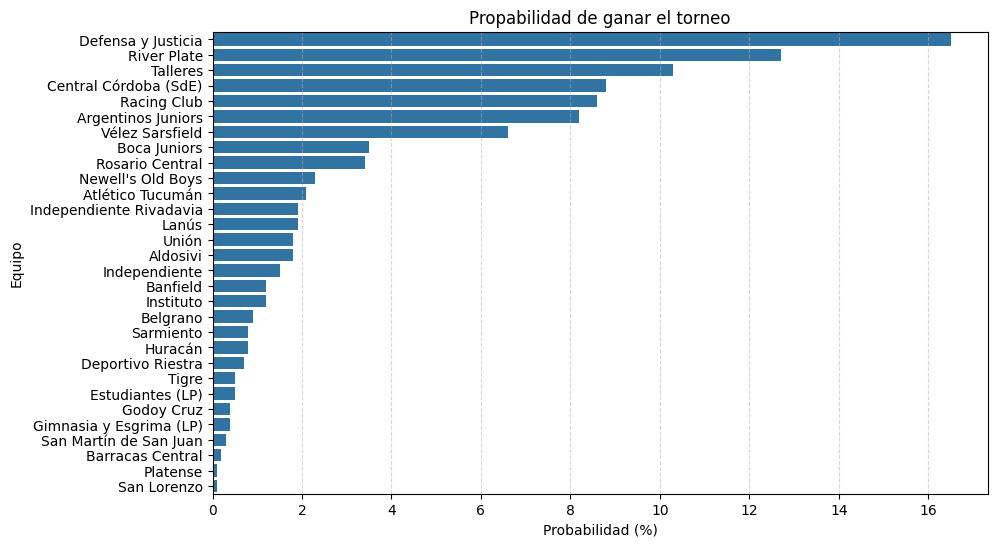

In [ ]:
from collections import Counter
conteo = Counter(campeones)
total_elementos = len(campeones)

# Porcentaje de cada elemento
porcentajes = {elem: (count / total_elementos) * 100 for elem, count in conteo.items()}
porcentajes_ordenados = dict(sorted(porcentajes.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 6))  # (Filas, Columnas)

sns.barplot(y=list(porcentajes_ordenados.keys()), x=list(porcentajes_ordenados.values()), ax=ax)
ax.set_title("Propabilidad de ganar el torneo (1000 simulaciones)")
ax.set_xlabel("Probabilidad (%)")
ax.set_ylabel("Equipo")
ax.grid(axis="x", linestyle="--", alpha=0.5)